# Synthetic data experiment

In [1]:
import torch
import torch.optim as optim

from models import Linear
from synthetic_data import GenerateDataset, SynDataset, DatasetFromList
from loss import hinge_loss01, OAT_loss

from tqdm import tqdm
from plot_utils import PlotEval
import os



/Users/rpukdee/opt/anaconda3/envs/adv_train2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def train(model, train_loader, loss, optimizer, num_epochs):
    for _ in range(num_epochs):
        for _, (X,y) in enumerate(train_loader):
            X,y = X.to(device), y.to(device)
            pre = model(X).flatten()
            cost = loss(pre, y.flatten())

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()


def AT_SVM(name, model, num_epochs, train_data, eps, batch_size1, batch_size2 = 100, num_epochs2 = 5, lr = 0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)
    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=batch_size1,
                                            shuffle=False)
    for epoch in tqdm(range(num_epochs)):
        for _, (X,y) in enumerate(train_loader):
            # Generate adversarial example
            N = X.shape[0]
            d = X.shape[1]
            weight = model.state_dict()['linear.0.weight'] 
            sign = 1*(weight > 0) - 1*(weight < 0)
            delta = eps* sign.repeat(N,1) * (y.repeat(d, 1).transpose(1,0)*2 - 1)
            X_adv = (X - delta).detach()

            # Train model
            dataset_i = DatasetFromList([X_adv],[y])
            train_loader_i = torch.utils.data.DataLoader(dataset=dataset_i,
                                                    batch_size=batch_size2,
                                                    shuffle=True)
            
            train(model, train_loader_i, hinge_loss01, optimizer, num_epochs = num_epochs2)

        torch.save(model.state_dict(), 'checkpoint/'+ name + '_epoch_'+ str(epoch))


    
def oat_train(model, train_loader, optimizer, num_epochs, eps):
    for _ in range(num_epochs):
        for _, (X,y) in enumerate(train_loader):
            X,y = X.to(device), y.to(device)
            cost = OAT_loss(model, X, y.flatten(), eps)

            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

def OAT_SVM(name, model, num_epochs, train_data, eps, batch_size1, batch_size2 = 100, num_epochs2 = 5, lr = 0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.01)
    train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                            batch_size=batch_size2,
                                            shuffle=False)
    for epoch in tqdm(range(num_epochs)):
        oat_train(model, train_loader, optimizer, num_epochs= num_epochs2, eps = eps)
        torch.save(model.state_dict(), 'checkpoint/'+ name + '_epoch_'+ str(epoch))



In [4]:
'''
Parameters for synthetic dataset
d = Number of non-robust features
p = Probability that a robust feature is correct
mu = Mean of non-robust features
sigma = Std of non-robust features
eps = Perturbation budget
'''

d = 2000
p = 0.7
mu = 1e-2
sigma = 1e-2
eps = 2e-2

train_size = 10000
test_size = 10000

GenerateDataset(p,mu,sigma,d, train_size, test_size)
syn_train = SynDataset(train = True)
syn_test = SynDataset(train = False)

batch_size1 = train_size
batch_size2 = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_loader = torch.utils.data.DataLoader(dataset=syn_test,
                                        batch_size=batch_size1,
                                        shuffle=False)
try:
    print('--- Creating a directory ---')
    os.mkdir('checkpoint')
except:
    print('--- The directory exists ---')

# Adversarial training
model = Linear(in_feature= d+1, out_feature= 1)
AT_SVM('AT_SVM', model, 50, syn_train, eps = eps, batch_size1 = train_size, 
batch_size2 = 200, num_epochs2 = 5, lr = 0.01)



# Optimal adversarial training
model = Linear(in_feature= d+1, out_feature= 1)
OAT_SVM('OAT_SVM', model, 50, syn_train, eps = eps, batch_size1 = train_size, 
batch_size2 = 200, num_epochs2 = 1, lr = 0.01)

--- Creating a directory ---
--- The directory exists ---


100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


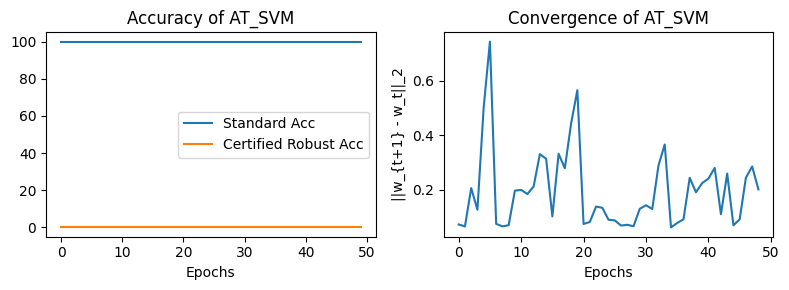

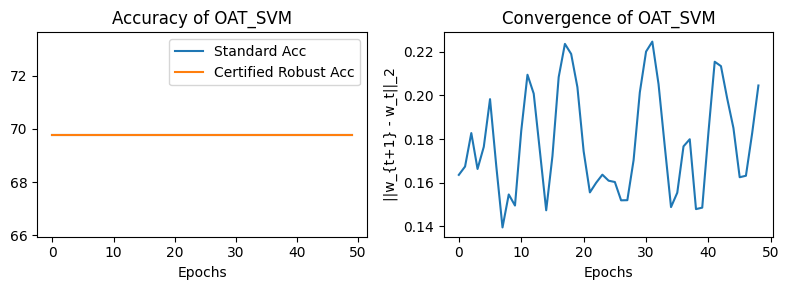

In [7]:
# Plot
PlotEval('AT_SVM', 50, Linear(in_feature= d+1, out_feature = 1), test_loader, eps = eps)
PlotEval('OAT_SVM', 50, Linear(in_feature= d+1, out_feature = 1), test_loader, eps = eps)
